# Charged Patchy Particle Model
_Alexei Abrikossov and Mikael Lund, December 2016_

In this Notebook we setup an MC simulation to calculate the interaction free energy between a pair
of CPPM's.

In [65]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy import integrate
import pandas as pd
import os.path, os, sys, json, shutil, glob
from pathlib import Path
import pickle
from sys import stdout
from math import exp, sqrt
#import mdtraj as md

#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})
#plt.rc('text', usetex=True)

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/lunarc/nobackup/users/mikael/github/cppm


### Download and compile the MC software Faunus

In [5]:
%%bash -s "$workdir"
module add GCC/6.2.0-2.27
module add CMake
cd $1

if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
  git checkout 8d7984e04c3e761b28572ea4b37a1ace8f917d59
else
  cd faunus
fi

# if different, copy custom gctit.cpp into faunus
if ! cmp ../mc/twobody.cpp src/examples/twobody.cpp >/dev/null 2>&1
then
    cp ../mc/twobody.cpp src/examples/
fi

CXX=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/g++ CC=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/gcc cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=off -DENABLE_OPENMP=off #&>/dev/null
make example_twobody -j4
cd $1

-- Could NOT find Doxygen (missing:  DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /lunarc/nobackup/users/mikael/github/cppm/faunus
[  8%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile.c.o
[ 25%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile_xtc.c.o
[ 25%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile_trr.c.o
[ 33%] Linking C static library libxdrfile.a
[ 33%] Built target xdrfile
[ 58%] Building CXX object src/CMakeFiles/libfaunus.dir/geometry.cpp.o
[ 66%] Building CXX object src/CMakeFiles/libfaunus.dir/slump.cpp.o
[ 66%] Building CXX object src/CMakeFiles/libfaunus.dir/potentials.cpp.o
[ 66%] Building CXX object src/CMakeFiles/libfaunus.dir/species.cpp.o
[ 75%] Building CXX object src/CMakeFiles/libfaunus.dir/analysis.cpp.o
[ 83%] Linking CXX shared library libfaunus.so
[ 83%] Built target libfaunus
[ 91%] Building CXX object src/examples/CMakeFiles/example_twobody.dir/twobody.cpp.o
[100%

......................................................................
  Faunus is running in Release mode recommended for production runs.
  For setting up simulations it is HIGHLY recommended to use Debug
  mode to enable run-time checks and assertions:

  -DCMAKE_BUILD_TYPE=RelWithDebInfo
**********************************************************************



### Function for generating JSON input file for Faunus

In [66]:
import os.path, os, sys, json, shutil
from pathlib import Path

def mkinput(ions):
    js = {
          "energy" : {
            "nonbonded" : {
              "coulomb" : { "epsr" : 78.7 },
              "lj" : {
                    "__custom__" : {
                        "MP Na": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "MP La": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "MP Cl": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "NP La": dict(sigma=3.0, eps=1.6),
                      }
                    }
            },

            "cmconstrain" : {
              "0sphere 1sphere" : { "mindist": 0, "maxdist": 99 }
              }
            },

          "atomlist" : {
            "UP":  dict(q=0,  sigma=4.0, eps=ljeps, mw=1e-3),
            "NP":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3),
            "PP":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3),
            "MP":  dict(q=0,  sigma=40,  eps=ljeps, mw=1e6),
            "Na":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3, dp=50),
            "La":  dict(q=3,  sigma=1.0, eps=ljeps, mw=1e-3, dp=10),
            "Cl":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3, dp=50)
              },

          "moleculelist": {
              "0sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 "+str(offset)},
              "1sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -"+str(offset)}
              },

          "moves" : {
              "moltransrot2body" : {
                "0sphere" : { "dp":dp, "dprot":0.5 }, 
                "1sphere" : { "dp":dp, "dprot":0.5 } 
                }
          },
          "analysis" : {
            "pqrfile" : { "file": "confout.pqr"  },
            "statefile" : { "file": "state" },
            "xtcfile" : { "file": "traj.xtc", "nstep": nstep_xtc },
            "meanforce" : { "nstep": nstep_force, "groups": [0,1] },
            "chargemultipole" : {"nstep":1000, "mollist":["0sphere", "1sphere"]},
            "multipoledistribution" :
                { "file": "multipole.dat", "nstep":10, "groups":["0sphere", "1sphere"] }
          },

          "system" : {
              "temperature" : 298.15,
              "cylinder" : { "length" : cyllen, "radius" : cylradius },
              "mcloop"   : { "macro" : 10, "micro" : micro }
              }
          }
    
    for name, N in ions.items():
        if N>0:
            js['moleculelist'][name] = dict(Ninit=N, atomic=True, atoms=name)
            if not 'atomtranslate' in js['moves']:
                js['moves']['atomtranslate'] = {}
            js['moves']['atomtranslate'][name] = dict(peratom=True)

    with open('twobody.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        
def volume():
    return np.pi*cylradius**2 * cyllen

cylradius=55 # cylinder radius (angstrom)
cyllen=200   # cylinder length (angstrom)
ljeps=2.479 # LJ epsilon (kj/mol)
offset=40    # initial COM-COM separation (angstrom)
maxdist=500  # maximum allowed COM-COM distance (angstrom)
dp=4         # COM translational displacement parameter (angstrom)
nstep_xtc=0  # frequency for saving frames to xtc trajectory file
nstep_force=0# frequency for direct force calculation

In [14]:
def M2N(molarity):
    ''' Convert mol/l to nearest integer number of particles in cylinder '''
    return int( round( molarity * volume() * 1e-27 * 6.022e23 ) )

R_range = np.arange(39, 80, 0.5) # separation space to scan (angstrom)
param = pd.DataFrame({
    'Neutral' :
        dict(
            charge=0, xyzfile=workdir+'/mc/sphere-neutral-reduced.xyz',
            R=R_range, label=r'Neutral', color='black',
            cs=0, ions = dict(Na=0), ljeps=[0.2479]
        ),
    'P00-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P00-1:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ (50 mM 1:1)', color='blue',
            cs=0.05, ions = dict(Na=16+M2N(0.05), Cl=M2N(0.05)), ljeps=[2.479]
        ),
    'P00-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ (100 mM 1:1)', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    'P00-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ (5 mM 3:1)', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    'P00-3:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ (10 mM 3:1)', color='blue',
            cs=0.010, ions = dict(Na=16, La=M2N(0.010), Cl=3*M2N(0.010)), ljeps=[2.479]
        ),
    'P00-3:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ (50 mM 3:1)', color='blue',
            cs=0.05, ions = dict(Na=16, La=M2N(0.05), Cl=3*M2N(0.05)), ljeps=[2.479]
        ),
    'P18-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (50 mM 1:1)', color='blue',
            cs=0.05, ions = dict(Na=16+M2N(0.05), Cl=M2N(0.05)), ljeps=[2.479]
        ),
    'P18-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (100 mM 1:1)', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    'P18-3:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (10 mM 3:1)', color='blue',
            cs=0.010, ions = dict(Na=16, La=M2N(0.010), Cl=3*M2N(0.010)), ljeps=[2.479]
        ),
    'P18-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (5 mM 3:1)', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    'P18-3:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (50 mM 3:1)', color='blue',
            cs=0.05, ions = dict(Na=16, La=M2N(0.05), Cl=3*M2N(0.05)), ljeps=[2.479]
        ),
    'P00-1:1-10mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-point.aam',
            R=R_range, label=r'$\tilde{P}_0^0$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-10mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            R=R_range, label=r'$\tilde{P}_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P00-1:1-50mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-point.aam',
            R=R_range, label=r'$\tilde{P}_0^0$ 50 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.050), Cl=M2N(0.050)), ljeps=[2.479]
        ),
    'P18-1:1-50mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            R=R_range, label=r'$\tilde{P}_8^1$ 50 mM 1:1', color='blue',
            cs=0.050, ions = dict(Na=16+M2N(0.050), Cl=M2N(0.050)), ljeps=[2.479]
        )

    })
#param = param.T.drop(labels='P18-mono').T
#param = param.T.drop(labels='Neutral').T
#param = param.T.drop(labels='P00-tri').T
#param = param.T.drop(labels='P00-mono').T
#param = param[ ['Neutral']  ]
param.T

,R,charge,color,cs,ions,label,ljeps,xyzfile
Neutral,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",0,black,0,{'Na': 0},Neutral,[0.2479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-100mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$P_0^0$ (100 mM 1:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-10mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$P_0^0$ 10 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-10mM-point,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$\tilde{P}_0^0$ 10 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-50mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.05,"{'Cl': 57, 'Na': 73}",$P_0^0$ (50 mM 1:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-50mM-point,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 57, 'Na': 73}",$\tilde{P}_0^0$ 50 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-10mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 33, 'Na': 16, 'La': 11}",$P_0^0$ (10 mM 3:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-50mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.05,"{'Cl': 171, 'Na': 16, 'La': 57}",$P_0^0$ (50 mM 3:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-5mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.005,"{'Cl': 18, 'Na': 16, 'La': 6}",$P_0^0$ (5 mM 3:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P18-1:1-100mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$P_8^1$ (100 mM 1:1),[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...


## Potential of mean force from histogram method

We first calculate the potential of mean force between two neutral spheres by simply sampling the COM-COM distance probability distribution, followed by Boltzmann inversion. Later we can check this result by comparing with PMFs obtained from direct sampling of the mean force from simulations where the particles are kept at fixed positions.

The COM's of the two macromolecules are able to translate along a line which coinsides with the axis of a cylindrical simulation cell with hard boundaries. During simulation, the molecules further rotate around their mass centers. Since the molecules in this way are constrained on a line, there is no need to correct for the increasing volume element normally needed for simulations in free space.

In [545]:
%%writefile $workdir/mc/submit.sh
#!/bin/bash

# This is a submit file, should you be using a cluster. Ignore this if running locally.

#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 40:00:00
../../faunus/src/examples/twobody > out

Overwriting /lunarc/nobackup/users/mikael/github/cppm/mc/submit.sh


In [374]:
%%bash
# kill all jobs
scancel `squeue -h | grep mikael | gawk '{print $1}'`

In [67]:
%cd -q $workdir/mc
for particletype, d in param.items(): # 'P00', 'P18', ...
    
    for eps in d.ljeps: # loop over LJ epsilon values
        
        ljeps = eps
        ionstr = ''
        for ion, N in d.ions.items(): # salt particles
            ionstr = ion+str(N) + ionstr

        directory = particletype

        #directory = 'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if not os.path.isdir(directory):
            %mkdir $directory
        if os.path.isdir(directory):
            %cd $directory

            if not os.path.isfile('out'):

                xyzfile=d.xyzfile
                nstep_force=0                # no force calculation
                offset=50/2.0                # COM offset from origo (center of container)
                dp=5                         # protein displacement on line (angstrom)
                micro=1000                    # number of micro steps (equilibration)
                mkinput( d.ions )             # make json input file for faunus

                !rm -fR state                # make sure there's no old state (restart) file
                !OMP_NUM_THREADS=4 nice ../../faunus/src/examples/twobody &> eq # eq. run

                micro=1000000                   # number of micro steps for production
                nstep_xtc=1000                  # save xtc file
                mkinput( d.ions )

                if shutil.which('sbatch') is not None: # run on slurm cluster...
                    !sbatch ../submit.sh
                else:                                  # ...or locally (slow) ?
                    !OMP_NUM_THREADS=4 ../../faunus/src/examples/twobody > out
                    
                nstep_xtc=0                  # disable xtc output for future simulations

            %cd -q ..

print('done.')

/lunarc/nobackup/users/mikael/github/cppm/mc/Neutral
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-100mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-10mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-50mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-5mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-1:1-100mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-1:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-1:1-10mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-1:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-1:1-50mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-3:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-3:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P18-3:1

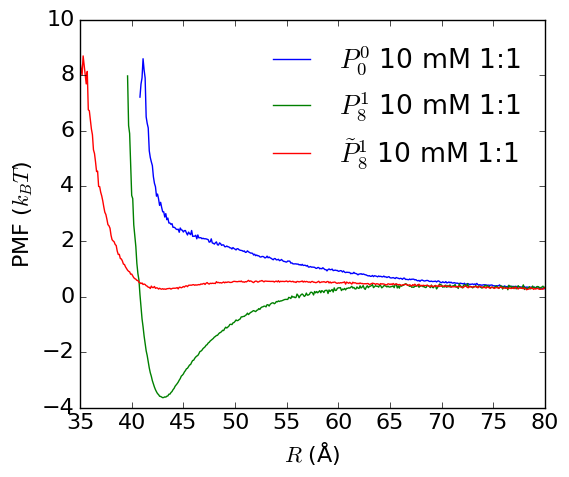

In [75]:
%cd -q $workdir/mc

from scipy.optimize import curve_fit

def f(r, D, shift, QQ):
    return 7*QQ/r*np.exp(-r/D) + shift

def fit(r, w):
    return curve_fit(f, xdata=r, ydata=w, p0=[3.04/sqrt(0.010), -10, 8*8])[0]

def plotpmf(plt, data, xlim, ljeps=2.479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        directory = particletype#'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('rdf.dat'):
                r, g = np.loadtxt('rdf.dat', unpack=True)
                w = -np.log(g)
                m = (r>65) & (r<87) # fitting interval
                D, shift, QQ = fit(r[m],w[m])
                plt.plot(r, w-shift, label=d.label)#, color=d.color)

            %cd -q ..

    plt.legend(loc=0, frameon=False)
    plt.xlabel('$R$ (Å)')
    plt.ylabel('PMF ($k_BT$)')
    plt.xlim(xlim)
    #plt.ylim(-1,5)
    
#r=np.linspace(40,100,50)
#D=3.04/sqrt(0.010)
#plt.plot( r, 7*8*8/r*np.exp(-r/D), 'k--', label='Yukawa, $\lambda_D$='+str(D))

#ff, (ax1, ax2) = plt.subplots(1, 2)
plotpmf(plt, param[['P00-1:1-10mM', 'P18-1:1-10mM', 'P18-1:1-10mM-point']], xlim=[35,80] )
#plotpmf(plt, param[['P00-1:1-50mM', 'P18-1:1-50mM', 'P18-1:1-50mM-point']], xlim=[35,80] )

In [15]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ljeps=2.479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr
            
        directory = particletype#'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('multipole.dat'):
                r,exact,total,ionion,iondip,dipdip,ionquad, mucorr= np.loadtxt('multipole.dat', unpack=True, skiprows=2)
                plt.plot(r, exact, 'ko', alpha=0.6, ms=4, label='exact', markevery=4)
                plt.plot(r, total, 'k-', lw=2, label='multipole sum')
                plt.plot(r, ionion, lw=2, label='ion-ion')
                plt.plot(r, iondip, lw=2, label='ion-dipole')
                plt.plot(r, dipdip, lw=2, label='dipole-dipole')
                plt.plot(r, ionquad, lw=2, label='ion-quadrupole')
                plt.plot(r, mucorr*10, lw=1,label=r'$10\cdot\langle \mu_1\mu_2\rangle$')
                
                plt.title(d.label, verticalalignment='bottom')

            %cd -q ..

    #plt.plot(r_hist, w_hist, 'k--', ms=3, label='Neutral, histogram')
    plt.legend(loc=0, frameon=False, fontsize='x-small', ncol=2)
    plt.xlabel(r'$R$ (Å)')
    plt.ylabel(r'Electrostatic energy ($k_BT$)')
    plt.xlim(xlim)
    plt.ylim(-10,15)

In [73]:
plotpmf(param[['P18-1:1-10mM']], xlim=[40,100] )

TypeError: plotpmf() missing 1 required positional argument: 'data'

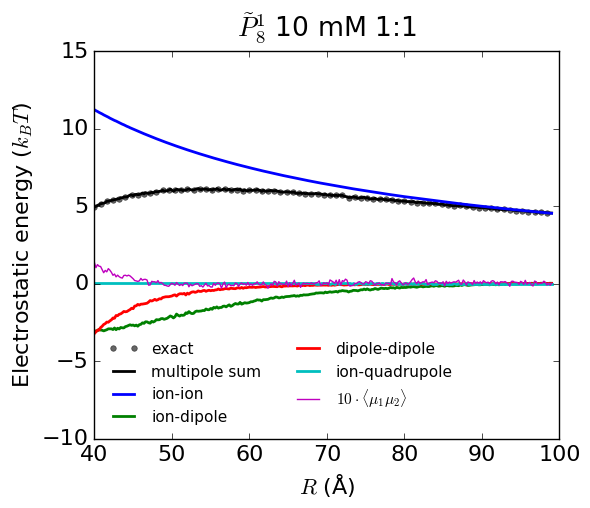

In [17]:
plotpmf(param[['P18-1:1-10mM-point']], xlim=[40,100] )

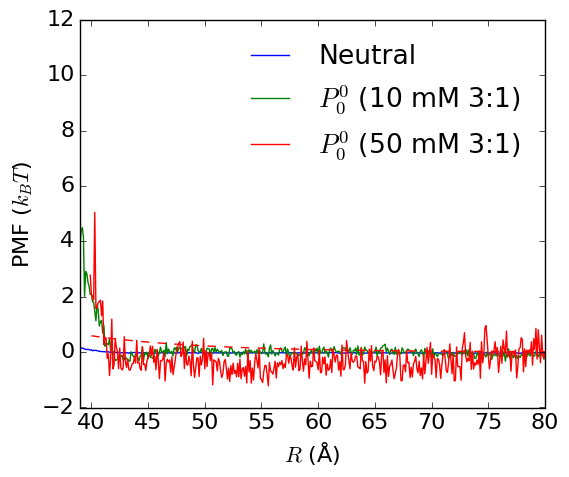

In [134]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ljeps=0.2479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        directory = 'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('rdf.dat'):
                r, g = np.loadtxt('rdf.dat', unpack=True)
                g = g / g[-1]
                plt.plot(r, -np.log(g), label=d.label)#, color=d.color)

            %cd -q ..

    #plt.plot(r_hist, w_hist, 'k--', ms=3, label='Neutral, histogram')
    plt.legend(loc=0, frameon=False)
    plt.xlabel('$R$ (Å)')
    plt.ylabel('PMF ($k_BT$)')
    plt.xlim(xlim)
    #plt.ylim(-1,5)
    
plotpmf(param[['Neutral', 'P00-3:1-10mM', 'P00-3:1-50mM']], xlim=[39,80] )
r=np.linspace(40,80,50)
D=3.04/sqrt(0.050)
plt.plot( r, 7*8*8/r*np.exp(-r/D), 'r--')

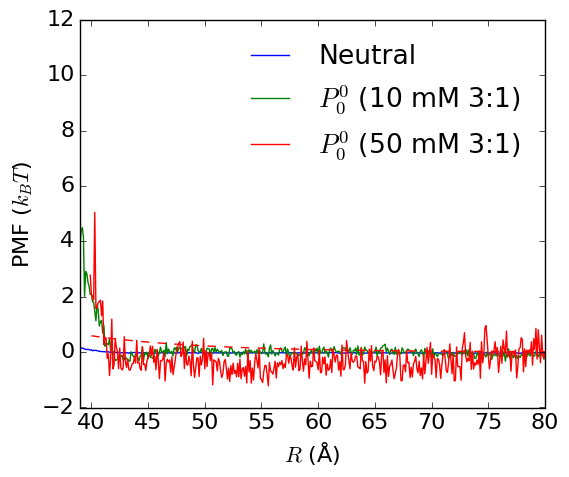

In [134]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ljeps=0.2479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        directory = 'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('rdf.dat'):
                r, g = np.loadtxt('rdf.dat', unpack=True)
                g = g / g[-1]
                plt.plot(r, -np.log(g), label=d.label)#, color=d.color)

            %cd -q ..

    #plt.plot(r_hist, w_hist, 'k--', ms=3, label='Neutral, histogram')
    plt.legend(loc=0, frameon=False)
    plt.xlabel('$R$ (Å)')
    plt.ylabel('PMF ($k_BT$)')
    plt.xlim(xlim)
    #plt.ylim(-1,5)
    
plotpmf(param[['Neutral', 'P00-3:1-10mM', 'P00-3:1-50mM']], xlim=[39,80] )
r=np.linspace(40,80,50)
D=3.04/sqrt(0.050)
plt.plot( r, 7*8*8/r*np.exp(-r/D), 'r--')

## Mean force calculation for fixed separations

In multivalent electrolyte solution, highly charged ion may "stick" to the molecule surface, making translational and rotational moves diffucult (low acceptance). To counter this, we sample the PMF by calculating for mean force on the macro-particles at fixed separations. The PMF is obtained by subsequent integration.

An automated setup is used and in the following cell, we create a Pandas structure describing how the simulations should be run and plotted (number of ions, macro-particle structure, colors, etc).

In [72]:
%cd -q $workdir/mc
for particletype, d in param.items(): # 'P00', 'P18', ...
    
    for eps in d.ljeps: # loop over LJ epsilon values
        
        ljeps = eps
        ionstr = ''
        for ion, N in d.ions.items(): # salt particles
            ionstr = ion+str(N) + ionstr

        for R in d.R:  # loop over defined COM-COM separations

            directory = particletype + '-' + ionstr + '-eps' + str(ljeps) + '-R' + str(R)
            if not os.path.isdir(directory):
                %mkdir $directory
            if os.path.isdir(directory):
                %cd -q $directory
                
                if not os.path.isfile('out'):

                    nstep_force = 10 # frequency to sample direct force
                    dp=0           # macromolecules do not move
                    offset = R/2.0 # initial COM distance from origo
                    micro=1000
                    xyzfile = d.xyzfile
                    nstep_xtc=0
                    mkinput( d.ions )

                    !rm -fR state
                    !OMP_NUM_THREADS=4 nice ../../faunus/src/examples/twobody &> eq # equilibration

                    micro=1000000     # number of micro steps in production
                    mkinput( d.ions )

                    if shutil.which('sbatch') is not None: # run on slurm cluster...
                        !sbatch ../submit.sh
                    else:                                  # ...or locally (slow) ?
                        !OMP_NUM_THREADS=4 ../../faunus/src/examples/twobody > out

                %cd -q ..
print('done.')

Submitted batch job 334486
Submitted batch job 334487
Submitted batch job 334488
Submitted batch job 334489
Submitted batch job 334490
Submitted batch job 334491
Submitted batch job 334492
Submitted batch job 334493
Submitted batch job 334494
Submitted batch job 334495
Submitted batch job 334496
Submitted batch job 334497
Submitted batch job 334498
Submitted batch job 334499
Submitted batch job 334500
Submitted batch job 334501
Submitted batch job 334502
Submitted batch job 334503
Submitted batch job 334504
Submitted batch job 334505
Submitted batch job 334506
Submitted batch job 334507
Submitted batch job 334508
Submitted batch job 334509
Submitted batch job 334510
Submitted batch job 334511
Submitted batch job 334512
Submitted batch job 334513
Submitted batch job 334514
Submitted batch job 334515
Submitted batch job 334516
Submitted batch job 334517
Submitted batch job 334518
Submitted batch job 334519
Submitted batch job 334520
Submitted batch job 334521
Submitted batch job 334522
S

### Collect; analyse; and plot data

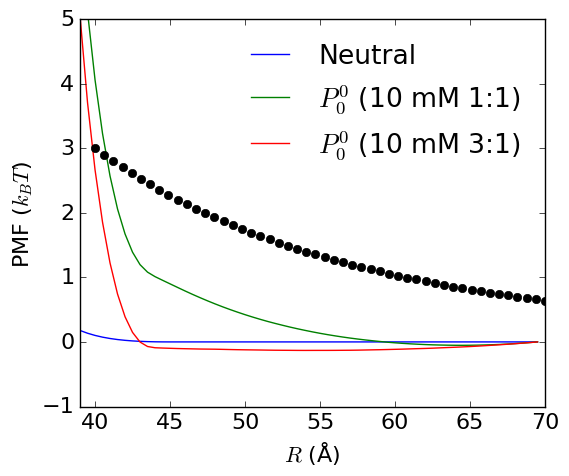

In [76]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ljeps):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        F = []         # mean force vs. distance
        for R in d.R:  # loop over defined COM-COM separations

            directory = particletype + '-' + ionstr + '-eps' + str(ljeps) + '-R' + str(R)
            if os.path.isdir(directory):
                %cd -q $directory
                
                with open('analysis_out.json') as file:    # simulation analysis is saved here...
                    j = json.load(file)['Mean force']['meanforce']
                    mf = np.array( j ).mean() # mean force on group 1 and 2
                    F.append( [R,mf]  )

                %cd -q ..

        if len(F) == d.R.shape[0]:
            r, f = np.array(F).T                      # r=distance (angstrom), f=mean force (kT/angstrom)
            w = integrate.cumtrapz( f, r, initial=0 ) # integrate force --> potential of mean force, w
            plt.plot(r, w-w[-1], label=d.label)#, color=d.color)

    #plt.plot(r_hist, w_hist, 'k--', ms=3, label='Neutral, histogram')
    plt.legend(loc=0, frameon=False)
    plt.xlabel('$R$ (Å)')
    plt.ylabel('PMF ($k_BT$)')
    plt.xlim(xlim)
    plt.ylim(-1,5)
    
plotpmf(param[['Neutral', 'P00-1:1-10mM', 'P00-3:1-10mM']], xlim=[39,70], ljeps=0.2479)
r=np.linspace(40,70,50)
D=3.04/sqrt(0.010)
plt.plot( r, 7*8*8/r*np.exp(-r/D), 'ko')

#r,gofr = np.loadtxt('hist-P00-1:1-5mM-Na19Cl3-eps0.2479/rdf.dat', unpack=True)
#plt.plot(r, -np.log(gofr)+11.4, 'g--', label='5 mM hist')